In [8]:
import pickle
import torch
import sys
import os
import numpy as np
from train_utils import *
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

sys.path.append('..')


In [2]:
model_name = 'newvalid' #'rho_reg_pecco'
trained_model = torch.load('../checkpoints/' + model_name + '.pth',map_location=torch.device('cpu'))
trained_model.eval()

ECCONetwork(
  (conv_fluid): EquiCtsConv2dRho1ToReg()
  (conv_obstacle): EquiCtsConv2dRho1ToReg()
  (dense_fluid): Sequential(
    (0): EquiLinearRho1ToReg()
    (1): EquiLinearRegToReg()
  )
  (convs): ModuleList(
    (0): EquiCtsConv2dRegToReg()
    (1): EquiCtsConv2dRegToReg()
    (2): EquiCtsConv2dRegToReg()
    (3): EquiCtsConv2dRegToRho1()
  )
  (denses): ModuleList(
    (0): EquiLinearRegToReg()
    (1): EquiLinearRegToReg()
    (2): EquiLinearRegToReg()
    (3): Sequential(
      (0): EquiLinearRegToReg()
      (1): EquiLinearRegToRho1()
    )
  )
)

In [3]:
from evaluate_network import evaluate
from datasets.argoverse_lane_loader import read_pkl_data
from argoverse.map_representation.map_api import ArgoverseMap


In [4]:
dataset_path = '../../argoverse_data/rose'
val_path = os.path.join(dataset_path, 'val') #, 'lane_data'
val_dataset = read_pkl_data(val_path, batch_size=1, shuffle=False, repeat=False)


In [30]:
with torch.no_grad():
    total_loss, prediction_gt = evaluate(trained_model, val_dataset,
                                       train_window=4, max_iter=3, 
                                       device='cpu', start_iter=0, 
                                        use_lane=False, batch_size=1)

evaluating.. 1 2 3 {'nll': array(154.70657, dtype=float32), 'ADE': 21.315464, 'ADE_std': 7.0893736, 'DE@1s': 6.6764693, 'DE@1s_std': 2.3366768, 'DE@2s': 36.60418, 'DE@2s_std': 11.25685, 'DE@3s': 48.56396, 'DE@3s_std': 23.850256}
done


In [35]:
def plot_id(key):
    pred = prediction_gt[key][0]
    gt = prediction_gt[key][1].numpy()

    M1 = torch.tanh(pred[:,2:].reshape(30,2,2))
    sigma = torch.einsum('...xy,...xz->...yz', M1, M1)
    new_M = torch.matrix_exp(sigma)
    pred = pred.numpy()
    new_M = new_M.numpy() 

    sig_x = np.sqrt(new_M[:,0,0])
    sig_y = np.sqrt(new_M[:,1,1])
    rho = new_M[:,0,1]/(sig_x*sig_y)

    fig = plt.figure(0, figsize=(8, 7))

    ax = fig.add_subplot(111, aspect='equal')

    plt.plot(gt[:,0],gt[:,1], c='r')
    plt.plot(pred[:,0],pred[:,1], c='orange')

    scale = 2*np.sqrt(5.991)
    ells = [Ellipse(xy=gaussian[:2], 
                    width=scale*sig_x[i], 
                    height=scale*sig_y[i], 
                    angle=np.arctan(rho[i]))
            for i, gaussian in enumerate(pred)]
    for e in ells:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.2)
        e.set_facecolor("#007672")

    plt.show()

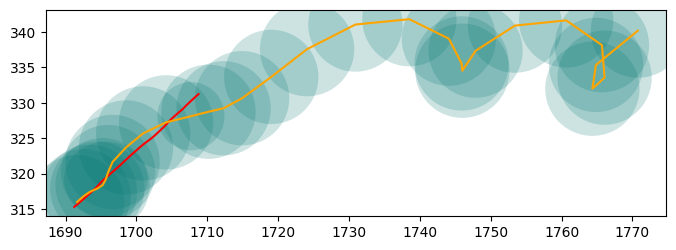

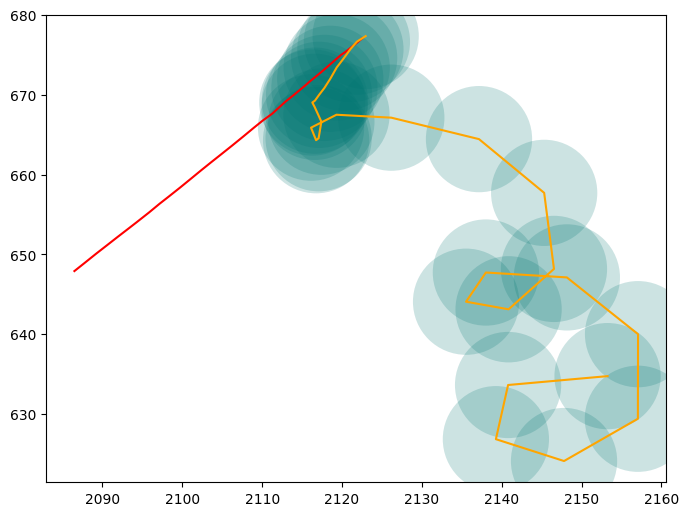

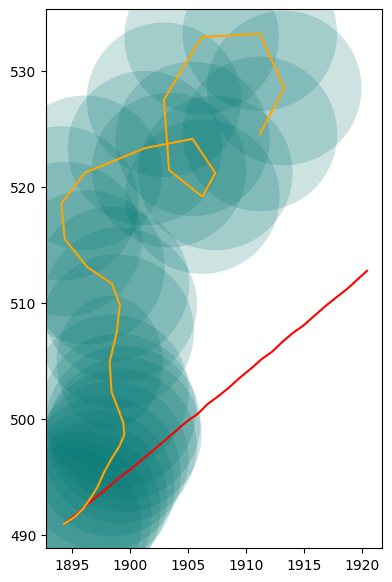

In [36]:
for k in prediction_gt.keys():
    plot_id(k)

In [ ]:
visualize_prediction()

In [23]:
import matplotlib.pyplot as plt

In [ ]:
from argoverse.map_representation.map_api import ArgoverseMap


In [24]:
def visualize_prediction(
    pos, track_id, agent_id, city_name, frame_id, lane_centerlines = None, show: bool = True, smoothen: bool = False
) -> None:
    lane_centerlines = a(afl[frame_id].seq_df, city_name) if lane_centerlines is None else lane_centerlines
    plt.figure(0, figsize=(8, 7))
    x_min = min(pos[:, 0])
    x_max = max(pos[:, 0])
    y_min = min(pos[:, 1])
    y_max = max(pos[:, 1])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)
    frames = df.groupby("TRACK_ID")
    plt.xlabel("Map X")
    plt.ylabel("Map Y")
    color_dict = {"AGENT": "#d33e4c", "OTHERS": "#13d4f2", "AV": "#007672"}
    object_type_tracker: Dict[int, int] = defaultdict(int)
    # Plot all the tracks up till current frame
    for group_name, group_data in frames:
        object_type = group_data["OBJECT_TYPE"].values[0]
        cor_x = group_data["X"].values
        cor_y = group_data["Y"].values
        if smoothen:
            polyline = np.column_stack((cor_x, cor_y))
            num_points = cor_x.shape[0] * 3
            smooth_polyline = interpolate_polyline(polyline, num_points)
            cor_x = smooth_polyline[:, 0]
            cor_y = smooth_polyline[:, 1]
        plt.plot(
            cor_x,
            cor_y,
            "-",
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )
        final_x = cor_x[-1]
        final_y = cor_y[-1]
        if object_type == "AGENT":
            marker_type = "o"
            marker_size = 7
        elif object_type == "OTHERS":
            marker_type = "o"
            marker_size = 7
        elif object_type == "AV":
            marker_type = "o"
            marker_size = 7
        plt.plot(
            final_x,
            final_y,
            marker_type,
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            markersize=marker_size,
            zorder=_ZORDER[object_type],
        )
        object_type_tracker[object_type] += 1
    red_star = mlines.Line2D([], [], color="red", marker="*", linestyle="None", markersize=7, label="Agent")
    green_circle = mlines.Line2D([], [], color="green", marker="o", linestyle="None", markersize=7, label="Others")
    black_triangle = mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=7, label="AV")
    plt.axis("off")

In [38]:
pred

[tensor([[[ 589.4445, 1381.8385]]]),
 tensor([[[ 589.6328, 1381.6088]]]),
 tensor([[[ 589.3992, 1380.2305]]]),
 tensor([[[ 588.9202, 1380.0366]]]),
 tensor([[[ 579.9214, 1367.5590]]]),
 tensor([[[ 584.3655, 1377.3729]]]),
 tensor([[[ 596.6658, 1271.8363]]]),
 tensor([[[ 640.7068, 1356.7920]]]),
 tensor([[[597.8172, 894.6785]]]),
 tensor([[[ 828.4139, 1853.6736]]]),
 tensor([[[  226.0106, -1018.5403]]]),
 tensor([[[1994.9950, 6174.8740]]]),
 tensor([[[ -2903.6455, -13136.2568]]]),
 tensor([[[10917.8076, 36676.0664]]]),
 tensor([[[-29450.9258, -93312.3594]]]),
 tensor([[[ 86699.4688, 243709.0000]]]),
 tensor([[[-246646.8906, -628298.2500]]]),
 tensor([[[ 739073.2500, 1645480.5000]]]),
 tensor([[[-2385644.5000, -4320317.0000]]]),
 tensor([[[ 7071482., 11239530.]]]),
 tensor([[[-20403056., -27931576.]]])]

In [39]:
gt

[tensor([[[ 587.6106, 1381.2997]]]),
 tensor([[[ 587.6106, 1381.2997]]]),
 tensor([[[ 586.9632, 1380.9113]]]),
 tensor([[[ 586.6739, 1380.7225]]]),
 tensor([[[ 586.3462, 1380.4492]]]),
 tensor([[[ 585.7589, 1379.9354]]]),
 tensor([[[ 585.4659, 1379.6121]]]),
 tensor([[[ 584.9191, 1379.0210]]]),
 tensor([[[ 584.6808, 1378.6652]]]),
 tensor([[[ 584.3546, 1378.2303]]]),
 tensor([[[ 583.8191, 1377.5601]]]),
 tensor([[[ 583.6369, 1377.1196]]]),
 tensor([[[ 583.3925, 1376.6952]]]),
 tensor([[[ 582.9846, 1375.8479]]]),
 tensor([[[ 582.7881, 1375.3280]]]),
 tensor([[[ 582.6030, 1374.8840]]]),
 tensor([[[ 582.4222, 1374.3217]]]),
 tensor([[[ 582.2029, 1373.8376]]]),
 tensor([[[ 582.0811, 1373.3918]]]),
 tensor([[[ 581.8999, 1372.7820]]]),
 tensor([[[ 581.7318, 1372.3556]]])]

In [31]:
prediction_gt.keys()

dict_keys([])